In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
    
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [13]:
df=pd.read_csv("sib.csv")
df['jour'] = pd.to_datetime(df['jour'])
df.set_index('jour', inplace=True)

df.head()

,cours
jour,
2021-01-01,2700
2021-01-04,2555
2021-01-05,2555
2021-01-06,2555
2021-01-07,2590


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 536 entries, 2021-01-01 to 2023-01-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cours   536 non-null    int64
dtypes: int64(1)
memory usage: 8.4 KB


<Axes: xlabel='jour'>

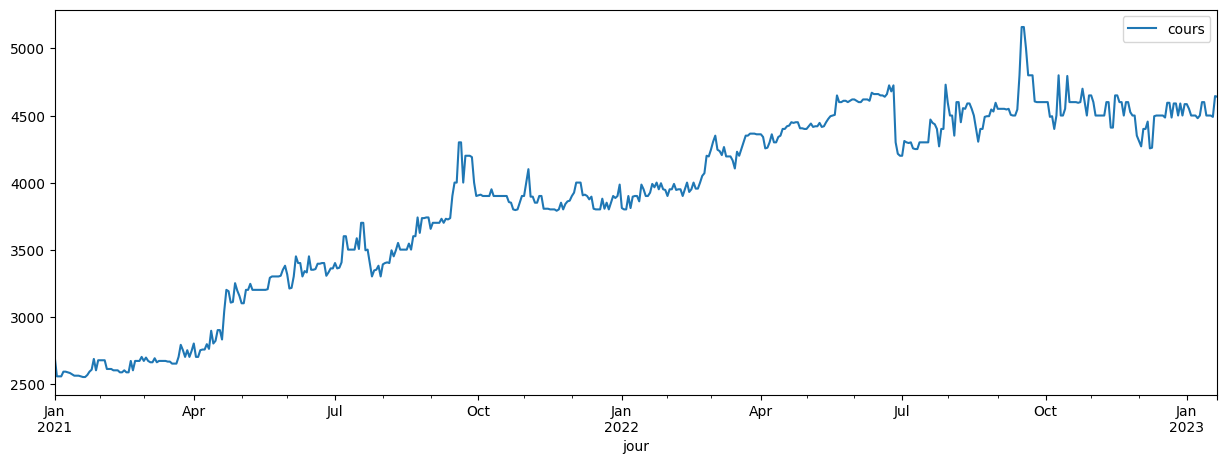

In [15]:
df.plot(figsize=(15,5))

In [16]:
TEST_SIZE = int(len(df)*0.30)
train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], df.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((376, 1), (376,), (160, 1), (160,))

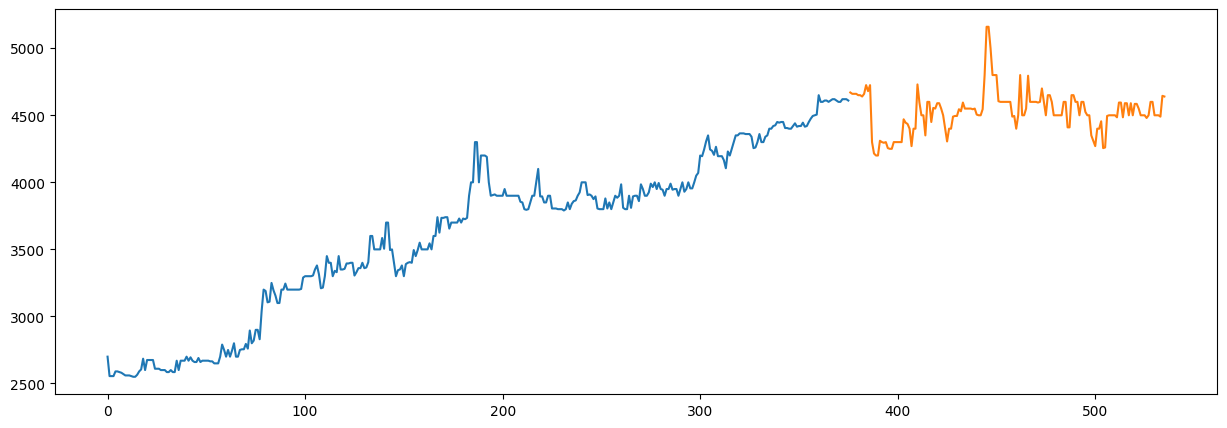

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [18]:
from pmdarima.arima import auto_arima

In [19]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,   
                      start_P=0, 
                      seasonal=False, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4124.837, Time=3.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4136.809, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4127.127, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4124.414, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4137.517, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4124.439, Time=4.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4126.238, Time=7.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4127.027, Time=1.40 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 19.769 seconds


In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  376
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2059.207
Date:                Sun, 14 Jul 2024   AIC                           4124.414
Time:                        13:36:37   BIC                           4136.195
Sample:                    01-01-2021   HQIC                          4129.091
                         - 06-10-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1936      2.478      2.096      0.036       0.336      10.051
ma.L1         -0.2152      0.037     -5.847      0.000      -0.287      -0.143
sigma2      3445.7235    139.672     24.670      0.000    3171.972    3719.475
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               341.43
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.20
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

2022-06-13    4618.727624
2022-06-14    4623.921204
2022-06-15    4629.114784
2022-06-16    4634.308364
2022-06-17    4639.501944
                 ...     
2023-01-16    5423.732530
2023-01-17    5428.926110
2023-01-18    5434.119690
2023-01-19    5439.313270
2023-01-20    5444.506850
Freq: B, Length: 160, dtype: float64

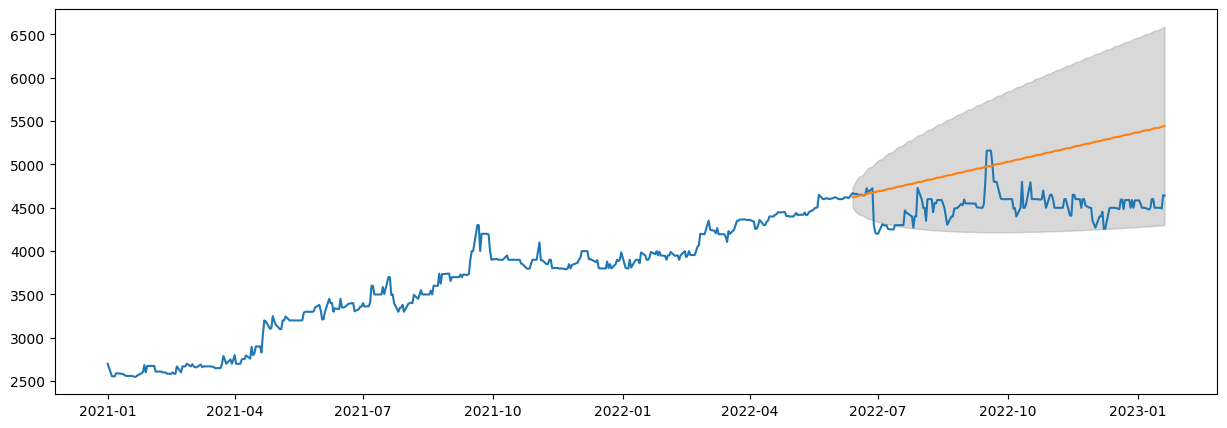

In [22]:
cf= pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.cours)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

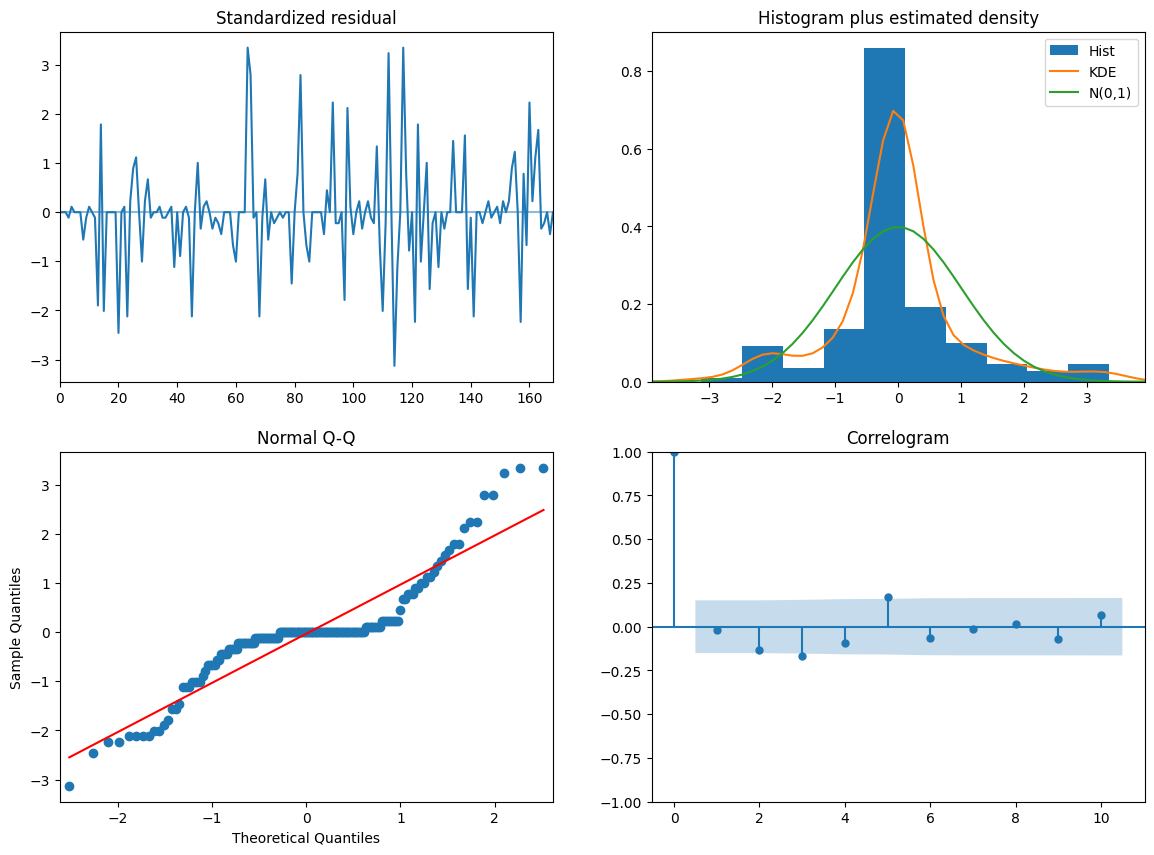

In [22]:
model.plot_diagnostics(figsize=(14,10))
plt.show()